<a href="https://colab.research.google.com/github/linhvien/Stock-analysis/blob/main/Vietnamese_stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import logging as logging
import re
import requests
import time
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math

In [44]:
start_date = '2015-01-01'
end_date = str(datetime.now().strftime('%Y-%m-%d'))
stock = 'VNM'
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
URL_CAFE = "http://s.cafef.vn/Lich-su-giao-dich-"
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36'}

In [32]:
def convert_date(text, date_type = '%Y-%m-%d'):
  return datetime.strptime(text, date_type)
  
def convert_text_dateformat(text, origin_type = '%Y-%m-%d', new_type = '%Y-%m-%d'):
  return convert_date(text, origin_type).strftime(new_type)


class DataLoadProto():
    def __init__(self, symbols, start, end, *arg, **karg):
        self.symbols = symbols
        self.start = convert_text_dateformat(start, new_type = '%d/%m/%Y')
        self.end = convert_text_dateformat(end, new_type = '%d/%m/%Y')

class DataLoaderCAFE(DataLoadProto):
    def __init__(self, symbols, start, end, *arg, **karg):
        self.symbols = symbols
        self.start = start
        self.end = end
        super(DataLoaderCAFE, self).__init__(symbols, start, end)

    def download(self):
        stock_datas = []
        if not isinstance(self.symbols, list):
            symbols = [self.symbols]
        else:
            symbols = self.symbols

        for symbol in symbols:
            stock_datas.append(self.download_one(symbol))

        data = pd.concat(stock_datas, axis=1)
        return data

    def download_one(self, symbol):
        stock_data = pd.DataFrame(columns=['date', 'close',
                                           'adjust'])

        for i in range(1000):
            stock_slice_batch = self.download_batch(i + 1, symbol)
            stock_data = pd.concat([stock_data, stock_slice_batch], axis=0)
            try:
                date_end_batch = stock_slice_batch.date.values[-1]
            except:
                # start date is holiday or weekend
                break
            is_touch_end = convert_date(self.start, '%d/%m/%Y') == convert_date(date_end_batch, '%d/%m/%Y')
            # logging.info('batch: {}; start date out range: {}; date_end_batch: {}'.format(i + 1, is_touch_end, date_end_batch))
            if is_touch_end:
                break

        stock_data = stock_data.set_index('date').apply(pd.to_numeric, errors='coerce')
        stock_data.index = list(map(lambda text: convert_date(text, date_type='%d/%m/%Y'), stock_data.index))
        stock_data.index.name = 'date'
        stock_data = stock_data.sort_index()
        stock_data.fillna(0, inplace=True)

        logging.info('data {} from {} to {} have already cloned!' \
                     .format(symbol,
                             convert_text_dateformat(self.start, origin_type = '%d/%m/%Y', new_type = '%Y-%m-%d'),
                             convert_text_dateformat(self.end, origin_type='%d/%m/%Y', new_type='%Y-%m-%d')))

        return stock_data

    def download_batch(self, id_batch, symbol):
        form_data = {'ctl00$ContentPlaceHolder1$scriptmanager':'ctl00$ContentPlaceHolder1$ctl03$panelAjax|ctl00$ContentPlaceHolder1$ctl03$pager2',
                       'ctl00$ContentPlaceHolder1$ctl03$txtKeyword':symbol,
                       'ctl00$ContentPlaceHolder1$ctl03$dpkTradeDate1$txtDatePicker':self.start,
                       'ctl00$ContentPlaceHolder1$ctl03$dpkTradeDate2$txtDatePicker':self.end,
                       '__EVENTTARGET':'ctl00$ContentPlaceHolder1$ctl03$pager2',
                       '__EVENTARGUMENT':id_batch,
                       '__ASYNCPOST':'true'}
        url = URL_CAFE+symbol+"-1.chn"
        r = requests.post(url, data = form_data, headers = headers, verify=False)
        soup = BeautifulSoup(r.content, 'html.parser')
        
        table = soup.find('table')
        stock_slice_batch = pd.read_html(str(table))[0].iloc[2:, :3]
        #print(stock_slice_batch)
        stock_slice_batch.columns = ['date', 'adjust', 'close']

        return stock_slice_batch


In [45]:
df = DataLoaderCAFE(stock,start_date,end_date).download()
df.head()

2021-09-26 17:53:45,554 : INFO : data VNM from 2015-01-01 to 2021-09-26 have already cloned!


,close,adjust
date,,
2015-01-05,96.0,35.14
2015-01-06,96.0,35.14
2015-01-07,98.0,35.87
2015-01-08,98.5,36.05
2015-01-09,103.0,37.70


In [46]:
df.shape

(1679, 2)

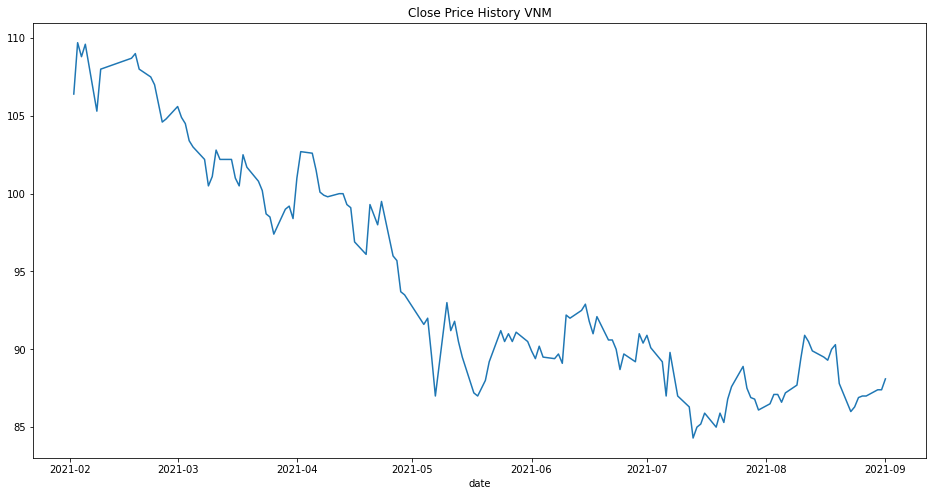

In [39]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History VNM')
plt.plot(df['close'])
plt.xlabel('date')
plt.show()

In [ ]:
#Create a new dataframe with only Close column
data = df.filter(['close'])
#Convert the dataframe to a numpy array
dataset = data.values
#Get 80% the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*.8)
#Scale the data
